Personalised Medicine: Redefining Cancer Treatment

In [1]:
from sklearn import *
import sklearn
import pandas as pd
import numpy as np
import xgboost as xgb

train = pd.read_csv('../input/training_variants')
test = pd.read_csv('../input/test_variants')
trainx = pd.read_csv('../input/training_text', sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
testx = pd.read_csv('../input/test_text', sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])

train = pd.merge(train, trainx, how='left', on='ID').fillna('')
y = train['Class'].values
train = train.drop(['Class'], axis=1)

test = pd.merge(test, testx, how='left', on='ID').fillna('')
pid = test['ID'].values

df_all = pd.concat((train, test), axis=0, ignore_index=True)
df_all['Gene_Share'] = df_all.apply(lambda r: sum([1 for w in r['Gene'].split(' ') if w in r['Text'].split(' ')]), axis=1)
df_all['Variation_Share'] = df_all.apply(lambda r: sum([1 for w in r['Variation'].split(' ') if w in r['Text'].split(' ')]), axis=1)

#commented for Kaggle Limits
#for i in range(56):
#    df_all['Gene_'+str(i)] = df_all['Gene'].map(lambda x: str(x[i]) if len(x)>i else '')
#    df_all['Variation'+str(i)] = df_all['Variation'].map(lambda x: str(x[i]) if len(x)>i else '')


gen_var_lst = sorted(list(train.Gene.unique()) + list(train.Variation.unique()))
print(len(gen_var_lst))
gen_var_lst = [x for x in gen_var_lst if len(x.split(' '))==1]
print(len(gen_var_lst))
i_ = 0
#commented for Kaggle Limits
#for gen_var_lst_itm in gen_var_lst:
#    if i_ % 100 == 0: print(i_)
#    df_all['GV_'+str(gen_var_lst_itm)] = df_all['Text'].map(lambda x: str(x).count(str(gen_var_lst_itm)))
#    i_ += 1

for c in df_all.columns:
    if df_all[c].dtype == 'object':
        if c in ['Gene','Variation']:
            lbl = preprocessing.LabelEncoder()
            df_all[c+'_lbl_enc'] = lbl.fit_transform(df_all[c].values)  
            df_all[c+'_len'] = df_all[c].map(lambda x: len(str(x)))
            df_all[c+'_words'] = df_all[c].map(lambda x: len(str(x).split(' ')))
        elif c != 'Text':
            lbl = preprocessing.LabelEncoder()
            df_all[c] = lbl.fit_transform(df_all[c].values)
        if c=='Text': 
            df_all[c+'_len'] = df_all[c].map(lambda x: len(str(x)))
            df_all[c+'_words'] = df_all[c].map(lambda x: len(str(x).split(' '))) 

train = df_all.iloc[:len(train)]
test = df_all.iloc[len(train):]

class cust_regression_vals(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        x = x.drop(['Gene', 'Variation','ID','Text'],axis=1).values
        return x

class cust_txt_col(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        return x[self.key].apply(str)

print('Pipeline...')
fp = pipeline.Pipeline([
    ('union', pipeline.FeatureUnion(
        n_jobs = -1,
        transformer_list = [
            ('standard', cust_regression_vals()),
            ('pi1', pipeline.Pipeline([('Gene', cust_txt_col('Gene')), ('count_Gene', feature_extraction.text.CountVectorizer(analyzer=u'char', ngram_range=(1, 8))), ('tsvd1', decomposition.TruncatedSVD(n_components=20, n_iter=25, random_state=12))])),
            ('pi2', pipeline.Pipeline([('Variation', cust_txt_col('Variation')), ('count_Variation', feature_extraction.text.CountVectorizer(analyzer=u'char', ngram_range=(1, 8))), ('tsvd2', decomposition.TruncatedSVD(n_components=20, n_iter=25, random_state=12))])),
            #commented for Kaggle Limits
            #('pi3', pipeline.Pipeline([('Text', cust_txt_col('Text')), ('tfidf_Text', feature_extraction.text.TfidfVectorizer(ngram_range=(1, 2))), ('tsvd3', decomposition.TruncatedSVD(n_components=50, n_iter=25, random_state=12))]))
        ])
    )])

train = fp.fit_transform(train); print(train.shape)
test = fp.transform(test); print(test.shape)

y = y - 1 #fix for zero bound array

denom = 0
fold = 1 #Change to 5, 1 for Kaggle Limits
for i in range(fold):
    params = {
        'eta': 0.03333,
        'max_depth': 4,
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'num_class': 9,
        'seed': i,
        'silent': True
    }
    x1, x2, y1, y2 = model_selection.train_test_split(train, y, test_size=0.18, random_state=i)
    watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
    model = xgb.train(params, xgb.DMatrix(x1, y1), 1000,  watchlist, verbose_eval=50, early_stopping_rounds=100)
    score1 = metrics.log_loss(y2, model.predict(xgb.DMatrix(x2), ntree_limit=model.best_ntree_limit), labels = list(range(9)))
    print(score1)
    #if score < 0.9:
    if denom != 0:
        pred = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit+80)
        preds += pred
    else:
        pred = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit+80)
        preds = pred.copy()
    denom += 1
    submission = pd.DataFrame(pred, columns=['class'+str(c+1) for c in range(9)])
    submission['ID'] = pid
    submission.to_csv('submission_xgb_fold_'  + str(i) + '.csv', index=False)
preds /= denom
submission = pd.DataFrame(preds, columns=['class'+str(c+1) for c in range(9)])
submission['ID'] = pid
submission.to_csv('submission_xgb.csv', index=False)

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


3260
3091


Pipeline...


(3321, 50)


(5668, 50)


[0]	train-mlogloss:2.14625	valid-mlogloss:2.1518


Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.



Will train until valid-mlogloss hasn't improved in 100 rounds.


[50]	train-mlogloss:1.22697	valid-mlogloss:1.37848


[100]	train-mlogloss:0.962159	valid-mlogloss:1.20367


[150]	train-mlogloss:0.811314	valid-mlogloss:1.13104


[200]	train-mlogloss:0.707752	valid-mlogloss:1.0993


[250]	train-mlogloss:0.628141	valid-mlogloss:1.07859


[300]	train-mlogloss:0.564709	valid-mlogloss:1.06977


[350]	train-mlogloss:0.511379	valid-mlogloss:1.06579


[400]	train-mlogloss:0.466618	valid-mlogloss:1.06384


[450]	train-mlogloss:0.42542	valid-mlogloss:1.06362


[500]	train-mlogloss:0.385764	valid-mlogloss:1.06294


Stopping. Best iteration:
[425]	train-mlogloss:0.446482	valid-mlogloss:1.06274



1.06274188304


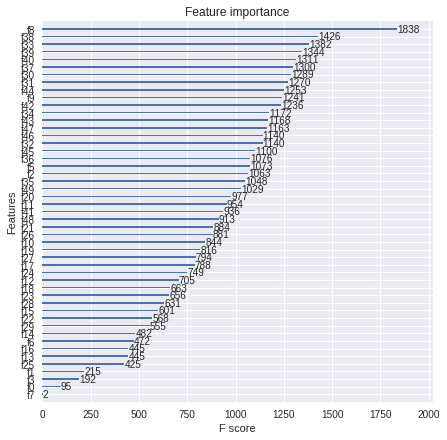

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (7.0, 7.0)
xgb.plot_importance(booster=model); plt.show()